# AIMaze EDA

As part of AIMaze’s project on the automated API code-generation system, we conducted an **Exploratory Data Analysis (EDA)** on each of 18 potential API’s services, provided by the AIMaze. The parsing part of the exploration aligns with the robots.txt conditions for all services. The goal was to understand how these docs are structured (single vs. multi-page, presence of machine-readable specs, authentication flows, etc.) and to measure properties like token counts, page lengths, and overall complexity, to understand the criteria for selecting proper LLM.

During this EDA:
- **Scraped** and formated all pages from each API’s documentation.
- **Tokenized** the resulting text.
- **Compared** token usage to the available context window of language model.
- **Analyze** more qualitative factors like the presence of multi-step flows, OAuth usage, rate limits, and official OpenAPI files.

By combining both **quantitative** data and **qualitative** insights, we aim to gain a more concise view of the challenges and for constraints in automated code generation.

## Quantitative Analysis
For the EDA we received 18 APIs AIMaze is/wants to use. We scraped all the pages in their documentations, which have been shrunk down (HTML converted to Markdown with excessive whitespaces removed) and tokenized using OpenAI's 'cl100k_base'. Initially we counted the tokens per endpoint to compare to the context size of expected models, but that quickly turned out not to be a concern (Claude 3.7 can hold 200K tokens, singular endpoints above 1.5K tokens were uncommon). Knowing endpoints will take up so little of the context size, the focus was shifted to token counts of pages and entire documentations.

The upper bound we'd like to stay under is 100K tokens. Considering the LLM's takes will be converting one standardized format (JSON/curl) to another (Python) it seems fair to assume the input and output will be roughly of equal size. Using only half of the context window will leave the other half for the LLM's code as it's being generated.

In [1]:
import json
from pprint import pprint

import numpy as np
import pandas as pd
import scipy.stats as st

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="darkgrid", palette=sns.color_palette("hls", 8))

In [2]:
with open("results.json", "r") as f:
    data = json.load(f)

data = [(base_url, url.replace(base_url, ""), n_tokens)
        for base_url, pages in data.items()
        for url, n_tokens in pages.items()]

df = pd.DataFrame(data, columns=("Website", "Page", "Token count"))

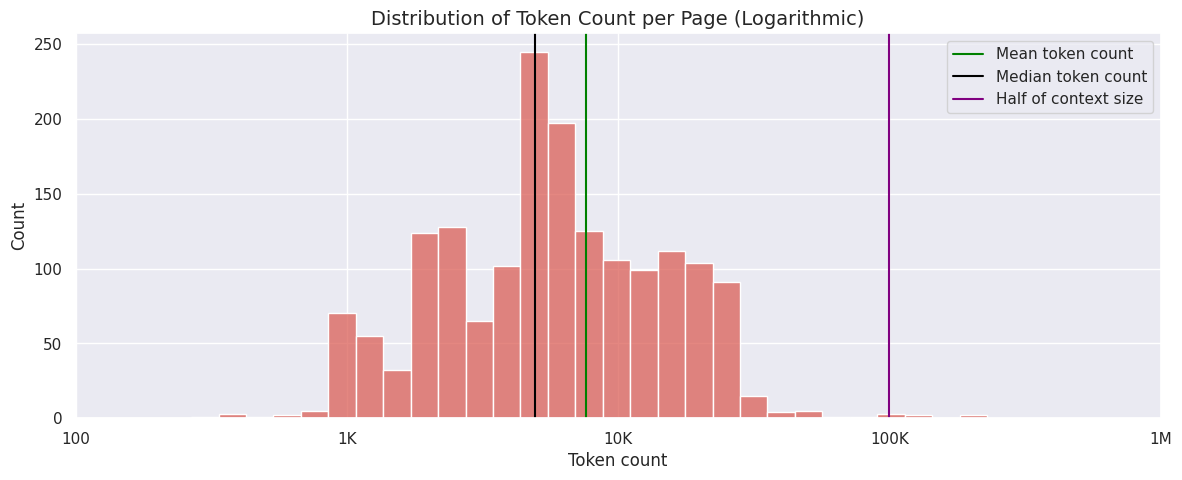

In [14]:
from math import sqrt

plt.figure(figsize=(14, 5))
sns.histplot(data=df, x="Token count", log_scale=10, bins=50)
plt.title("Distribution of Token Count per Page (Logarithmic)", fontsize=14)

plt.xticks(ticks=[100, 1_000, 10_000, 100_000, 1_000_000], labels= ["100", "1K", "10K", "100K", "1M"])
plt.xlim(100, 1_000_000)

CI95 = st.norm.interval(confidence=0.45,
                        loc=np.mean(df["Token count"]),
                        scale=np.std(df["Token count"]))


plt.axvline(x=np.mean(df["Token count"]), color='green', label='Mean token count')
plt.axvline(x=np.median(df["Token count"]), color='black', label='Median token count')
plt.axvline(x=100_000, color='purple', label='Half of context size')
# plt.axvline(x = CI95[0], color = 'darkblue', label = '95% CI min')
# plt.axvline(x = CI95[1], color = 'darkblue', label = '95% CI max')
plt.legend(loc='upper right')

The mean and median token count lie over an order of magnitude below the upper token bound. The off page with >100K tokens are 'monolithic' (entire documentation on one page). This means we generally don't have to worry about splitting up pages (until we get to the point of development where we'll handle the monolith edgecase) and can instead insert entire pages into the LLM prompt.

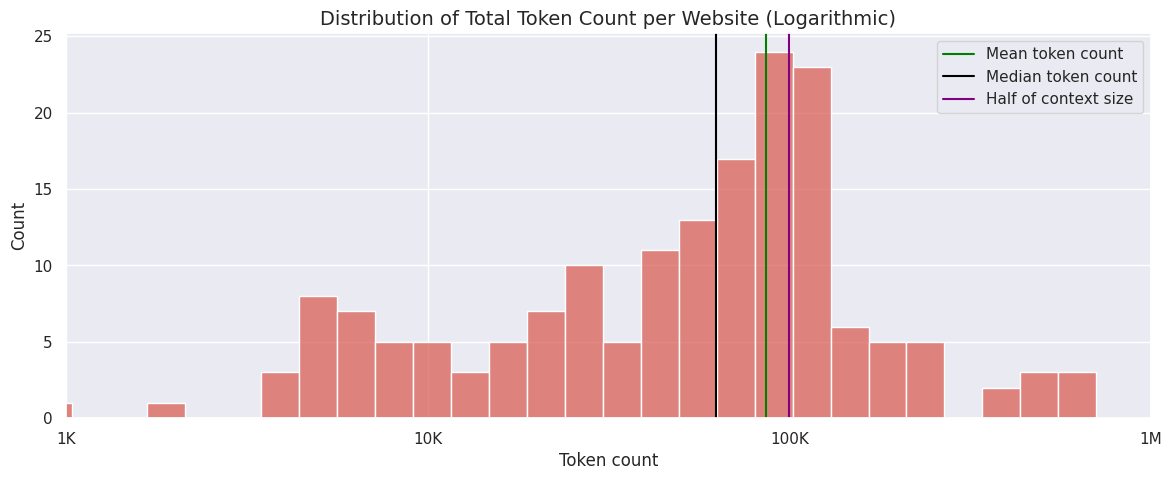

In [16]:
grouped = df.groupby('Website').agg(total=('Token count', 'sum'))

plt.figure(figsize=(14, 5))
sns.histplot(data=grouped, x="total", log_scale=10, bins=50)
plt.title("Distribution of Total Token Count per Website (Logarithmic)", fontsize=14)
plt.xlabel("Token count")
plt.xticks(ticks=[1_000, 10_000, 100_000, 1_000_000], labels= ["1K", "10K", "100K", "1M"])
plt.xlim(1_000, 1_000_000)


CI95 = st.norm.interval(confidence=0.95,
                        loc=np.mean(grouped["total"]),
                        scale=np.std(grouped["total"])/sqrt(len(grouped)-1))
# plt.axvline(x = CI95[0], color = 'darkblue', label = '95% CI min')
# plt.axvline(x = CI95[1], color = 'darkblue', label = '95% CI max')

plt.axvline(x=np.mean(grouped["total"]), color='green', label='Mean token count')
plt.axvline(x=np.median(grouped["total"]), color='black', label='Median token count')
plt.axvline(x=100_000, color='purple', label='Half of context size')

plt.legend(loc='upper right')

In [22]:
sorted_data = np.sort(grouped['total'])
rank = np.searchsorted(sorted_data, 100_000, side='left')
print(f"Upper bound as percentile: {(rank / len(sorted_data)) * 100:.2f}%")

Upper bound as percentile: 71.19%


~29% of entire API's are over our upper context bound. This means that, while we can get away with inserting entire API's into the LLM prompt for smaller API's in initial modeling, we'll need some way to properly split the docs for these 29% of cases.

## Qualitative Analysis

1. **Machine Readable Specs**
   - *6 out of 18* APIs provide official OpenAPI/Swagger files (e.g., aNewSpring, HubSpot, Asana, Magento, Bol.com, GitHub). These are highly advantageous for automatic code generation.
   - Another *5–6* (WooCommerce, Shopify, Notion, Stripe, eTrusted, Pipedrive) offer partial or unofficial specs. these might be useful, but probably won't be used in the system due to lack of reliability.

2. **Single-Page vs. Multi-Page**
   - *2 out of 18* (WooCommerce, Stripe) are single-page websites. These pages exceed typical token limits, so **chunking** is crucial to keep the data manageable.
   - The rest have multi-page docs, often more straightforward to parse.

3. **Nested Subcomponents**
   - Several APIs act as “wrappers” encompassing multiple sub-APIs (e.g., GitHub includes Actions, Billing, Codespaces).
   - Treating them as one monolith are often too big for LLM upper token bound. Most 'multi-page' API are structured in a way that such subcomponents can easily be recognized and captured as individual components.

4. **Multiple Version Pages**
   - Some documentations have multiple version pages for their API. For these cases we need to think of a way to get the most recent version of all.
   - Simple rules such as 'if found the same url, but one contains v2 and one v3, then only v3' could work okay, but we definitely found some variance is how this versioning is displayed.

5. **Access Tokens and Related Auth**
   - *13 out of 18* rely on either OAuth-based or personal token authentication, both requiring an **access token**.
   - *4* use a simpler key/secret model (WooCommerce, WebwinkelKeur, Pipedrive, Stripe).
   - Magento stands out with OAuth 1.0.

6. **Rate Limits**
   - *9 out of 18* explicitly mention numeric rate limits, enabling concurrency-limiting or “retry on 429” code.
   - The others either provide adaptive or no mention of a fixed quota.

7. **Multi-Step Flows**
   - *5 out of 18* (LinkedIn, Magento, Bol.com, Shopify, Microsoft Graph) detail more advanced, multi-call processes.

8. **Sandbox / Test Environments**
   - *5 out of 18* (Bol.com, Stripe, Shopify, HubSpot, Pipedrive) explicitly reference sandbox or special test modes.
   - Sandbox might be used as the testing benchmark for evaluating generated code.

9. **General vs. Endpoint-Specific Information**
   - Some details (e.g., authentication, rate limits, permission scopes) apply to *all* endpoints and must be included for generating every endpoint, since they provide the general information that is required to implement the endpoint.
   - Endpoint documentation only defines specifics (parameters, paths, request/response objects) which often is not enough to properly generate code.

10. **Monolithic Docs and Splitting**
   - Several single-page or large “all-in-one” docs surpass an upper token bound. To process them, chunking is required, to ensure none of the endpoints are cut into different flows, we also need to ensure the patches overlap and efficient duplicate cleaning is setup.

### **Analysis Conclusions**

1. **Machine-Readable Specs**
   - Setup the logic to search for any available official or partial OpenAPI specs to capture endpoints, request/response structures, and schema definitions, finding them will provide all the endpoints information that normally is parsed from HTMLs, this ensures more stable results and explainability of potential errors.

2. **Segmenting Large Docs**
   - For monolithic or wrapper-style (subcomponent) APIs (e.g., GitHub’s multiple services), subdivide them by topic or sub-API to avoid breaching token limits and to maintain clarity.

3. **Handling Multiple Versions**
   - Whenever multiple versions exist (v2, v3, etc.), adopt a rule that detects and prioritizes the latest. Remain flexible about naming patterns like “v3,” “3.x,” “3.0,” and so on.

4. **Access Token Model**
   - Most of the services use access token approach and header-based authentication, the additional information on details about authentication is always located on `Authentication` page, which is often accessible from the API landing page.

5. **Rate Limit Logic**
   - Handle the rate limits exceptions within code, the information about them should be retrieved from `Rate Limits` which is often listed in the landing page of the API.

6. **Workflow Awareness**
   - For APIs documenting multi-step or asynchronous flows, we will further evaluate the complexity during development and maybe set up system to notify the human developer to complete them.

7. **Smart Agent for Global Data**
   - Almost all Services, especially large APIs have unique approach of the system architecture. To properly generate the endpoint implementation, the agent requires to understand the API context, including Main Concepts, Entities, Auth methods, Scopes, Rate-Limits, etc. All this information is commonly located on the API "Landing Page"(`Overview` or `Getting Started`). A system needs to gather this general info using a “smart agent” or specialized logic can navigate the website more efficiently that BFS traverse to harvest universal data and carry it into endpoint-level generation.
